In [ ]:
#clone repo
!git clone https://github.com/mattwang44/LeNet-from-Scratch.git

#move inside the folder
%cd LeNet-from-Scratch
!mkdir -p MNIST

Cloning into 'LeNet-from-Scratch'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 134 (delta 1), reused 1 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (134/134), 1.21 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/LeNet-from-Scratch


Setting up LeNet-300-100...

[1] Training Baseline Model...
Training Epoch 1/5...
Training Epoch 2/5...
Training Epoch 3/5...
Training Epoch 4/5...
Training Epoch 5/5...

[2] Pruning Model (Removing 90% of connections)...

[3] Quantizing Model (Float32 -> Int8)...

RESULTS FOR LENET-300-100 (MNIST)
Version              | Size (MB)  | Accuracy  
--------------------------------------------------
Baseline             | 1.0199     | 97.47%
Pruned (90%)         | 1.0199     | 91.92%
Pruned + Quantized   | 0.2662     | (Similar)
--------------------------------------------------
COMPRESSION RATIO: 3.8x smaller

Generating Efficiency Chart...


/tmp/ipython-input-2061104024.py:192: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


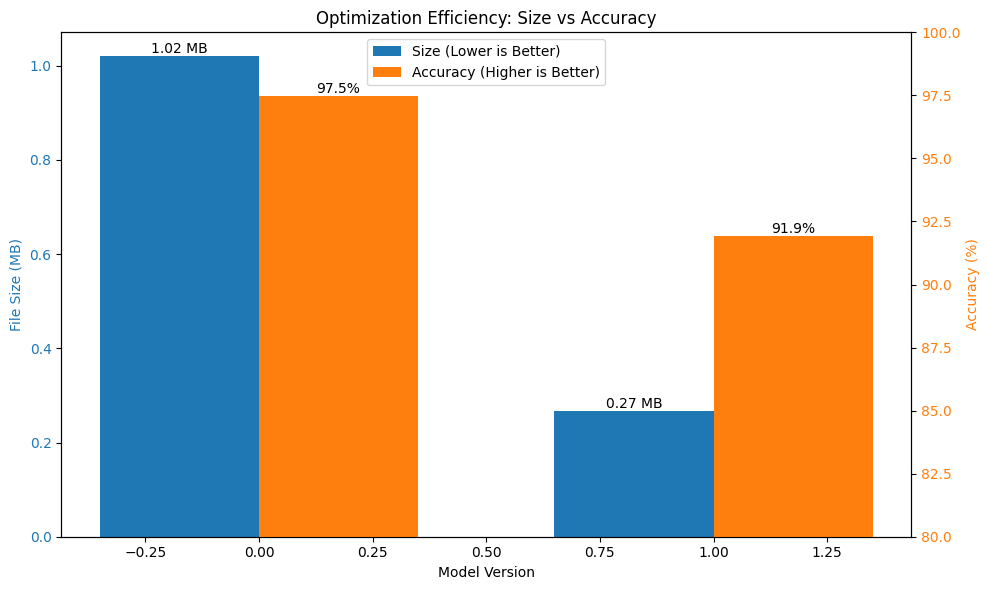

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune
import os
import matplotlib.pyplot as plt
import numpy as np


BATCH_SIZE = 64 #scrutiniizes 64 images at a time
EPOCHS = 5  #goes through the entire image set 5 times
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check the presence of gpu, else use cpu


#Filtering and narrowing down
class LeNet300100(nn.Module):
    def __init__(self):
        super(LeNet300100, self).__init__()
        #28x28 pixels = 784 pixels
        self.fc1 = nn.Linear(784, 300) #connect 784 pixels to 300 neurons to capture the patterns (arbitrary)
        self.relu1 = nn.ReLU() #filter out unimportant noise(virtual [i.e. smudges] /mathematical)

        self.fc2 = nn.Linear(300, 100) #narrows 300 neuron clues down to 100
        self.relu2 = nn.ReLU() #more filtering

        self.fc3 = nn.Linear(100, 10) #100 clues narrowed down to 0-9 (10 digits)

#template for when an image set is received
    def forward(self, x):
        x = x.view(-1, 784)  # flatten the image
        x = self.relu1(self.fc1(x)) #1st filter
        x = self.relu2(self.fc2(x)) #2nd filter
        x = self.fc3(x) #final narrowing
        return x #return the fina 0-9 values



#download and batch the images
def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),  #transform into tensor
        transforms.Normalize((0.1307,), (0.3081,)) #standard MNIST normalization
    ])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=BATCH_SIZE, shuffle=True)
    #test the model's accuracy
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=1000, shuffle=False)
    return train_loader, test_loader



#training the model (with training data)
def train(model, train_loader):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate of 0.001 (small measured steps)
    criterion = nn.CrossEntropyLoss() #measures error intensity
    for epoch in range(EPOCHS):
        print(f"Training Epoch {epoch+1}/{EPOCHS}...")
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward() #back propagation to find the exact error
            optimizer.step()


#testing the model (with test data)
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(test_loader.dataset)


#weigh file size to prove the optimization did work/became smaller
def get_file_size(file_path):
    size_in_bytes = os.path.getsize(file_path)
    return size_in_bytes / (1024 * 1024) # Convert to MB


#visualisation (Performance Chart)
def visualize_performance(baseline_size, quantized_size, baseline_acc, pruned_acc):
    """
    Creates a bar chart comparing Size (Optimization) vs Accuracy (Performance).
    """
    labels = ['Baseline', 'Optimized']

    # Data for the chart
    sizes = [baseline_size, quantized_size]
    accuracies = [baseline_acc, pruned_acc] # Using pruned acc as final acc proxy

    x = np.arange(len(labels))  # label locations
    width = 0.35  # width of the bars

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar 1: File Size (Blue)
    color = 'tab:blue'
    ax1.set_xlabel('Model Version')
    ax1.set_ylabel('File Size (MB)', color=color)
    bars1 = ax1.bar(x - width/2, sizes, width, label='Size (Lower is Better)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Add text labels on top of size bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} MB', ha='center', va='bottom')

    # Create a second y-axis for Accuracy
    ax2 = ax1.twinx()

    # Bar 2: Accuracy (Orange)
    color = 'tab:orange'
    ax2.set_ylabel('Accuracy (%)', color=color)
    bars2 = ax2.bar(x + width/2, accuracies, width, label='Accuracy (Higher is Better)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set accuracy range to look nice (e.g., 80-100%) so slight drops are visible
    ax2.set_ylim(80, 100)

    # Add text labels on top of accuracy bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    # Final formatting
    plt.title('Optimization Efficiency: Size vs Accuracy')
    fig.tight_layout()

    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

    plt.show() #show visualisation


#main execution
print("Setting up LeNet-300-100...")
train_loader, test_loader = get_data()
model = LeNet300100().to(device)

#training
print("\n[1] Training Baseline Model...")
train(model, train_loader)
baseline_acc = test(model, test_loader)
torch.save(model.state_dict(), "model_baseline.pth")
baseline_size = get_file_size("model_baseline.pth")

#pruning
print("\n[2] Pruning Model (Removing 90% of connections)...")
# Since this model is all Linear, we can prune heavily (90% sparsity)
parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9, # remove 90% of weights (detected through supervised learning + gradient descent)
)


for module, name in parameters_to_prune:
    prune.remove(module, name)

pruned_acc = test(model, test_loader)
torch.save(model.state_dict(), "model_pruned.pth")
pruned_size = get_file_size("model_pruned.pth")

#quantisation of the pruned model (to reduce the precision)
print("\n[3] Quantizing Model (Float32 -> Int8)...")
# Move to CPU for quantization
model_to_quantize = LeNet300100()
model_to_quantize.load_state_dict(torch.load("model_pruned.pth", map_location='cpu'))
model_to_quantize.eval()

quantized_model = torch.quantization.quantize_dynamic(
    model_to_quantize,
    {nn.Linear},
    dtype=torch.qint8
)

scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("model_quantized.pt")
quantized_size = get_file_size("model_quantized.pt")

#results table
print("\n" + "="*50)
print(f"RESULTS FOR LENET-300-100 (MNIST)")
print("="*50)
print(f"{'Version':<20} | {'Size (MB)':<10} | {'Accuracy':<10}")
print("-" * 50)
print(f"{'Baseline':<20} | {baseline_size:<10.4f} | {baseline_acc:.2f}%")
print(f"{'Pruned (90%)':<20} | {pruned_size:<10.4f} | {pruned_acc:.2f}%")
print(f"{'Pruned + Quantized':<20} | {quantized_size:<10.4f} | {'(Similar)'}")
print("-" * 50)
print(f"COMPRESSION RATIO: {baseline_size / quantized_size:.1f}x smaller")

#visualisation
print("\nGenerating Efficiency Chart...")
visualize_performance(baseline_size, quantized_size, baseline_acc, pruned_acc)

Short Notes
Filtering (ReLU): The Traffic Light

Pruning: The Bulldozer

The Data (Image): The Car

Pruning alters the Pathways (The Map)

Quantization alters the Content (The Precision)